<a href="https://colab.research.google.com/github/uwituzeb/sound-clustering-assignment/blob/main/Sound_clustering_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Unlabeled Sound Data**



In [ ]:
# Make all necessary Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import librosa
import librosa.display
import zipfile
import os


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the Data
zip_path = "/content/drive/MyDrive/unlabelled_sounds.zip"
extract_path = "/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds"

#Extract Features
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

audio_files = [f for f in os.listdir(extract_path) if f.endswith(".wav")]
# Extract files
features = []
for audio_file in audio_files:
    audio_path = os.path.join(extract_path, audio_file)
    signal, sr = librosa.load(audio_path) # Load audio file
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13) #Extract 13 MFCCS
    features.append(np.mean(mfccs.T, axis=0))

# Convert to NumPy array
features_array = np.array(features)


In [ ]:
features_array.shape

(3000, 13)

In [ ]:
print("Total audio files found:", len(audio_files))
print(audio_files[:5])

Total audio files found: 3000
['0.wav', '1.wav', '5.wav', '8.wav', '11.wav']


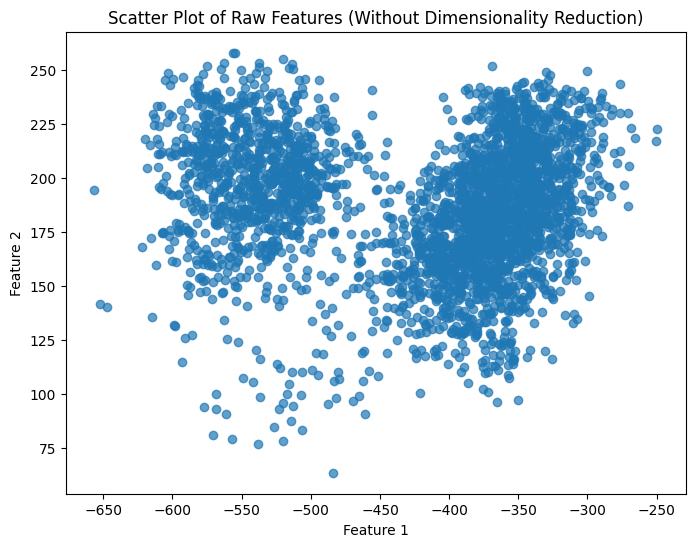

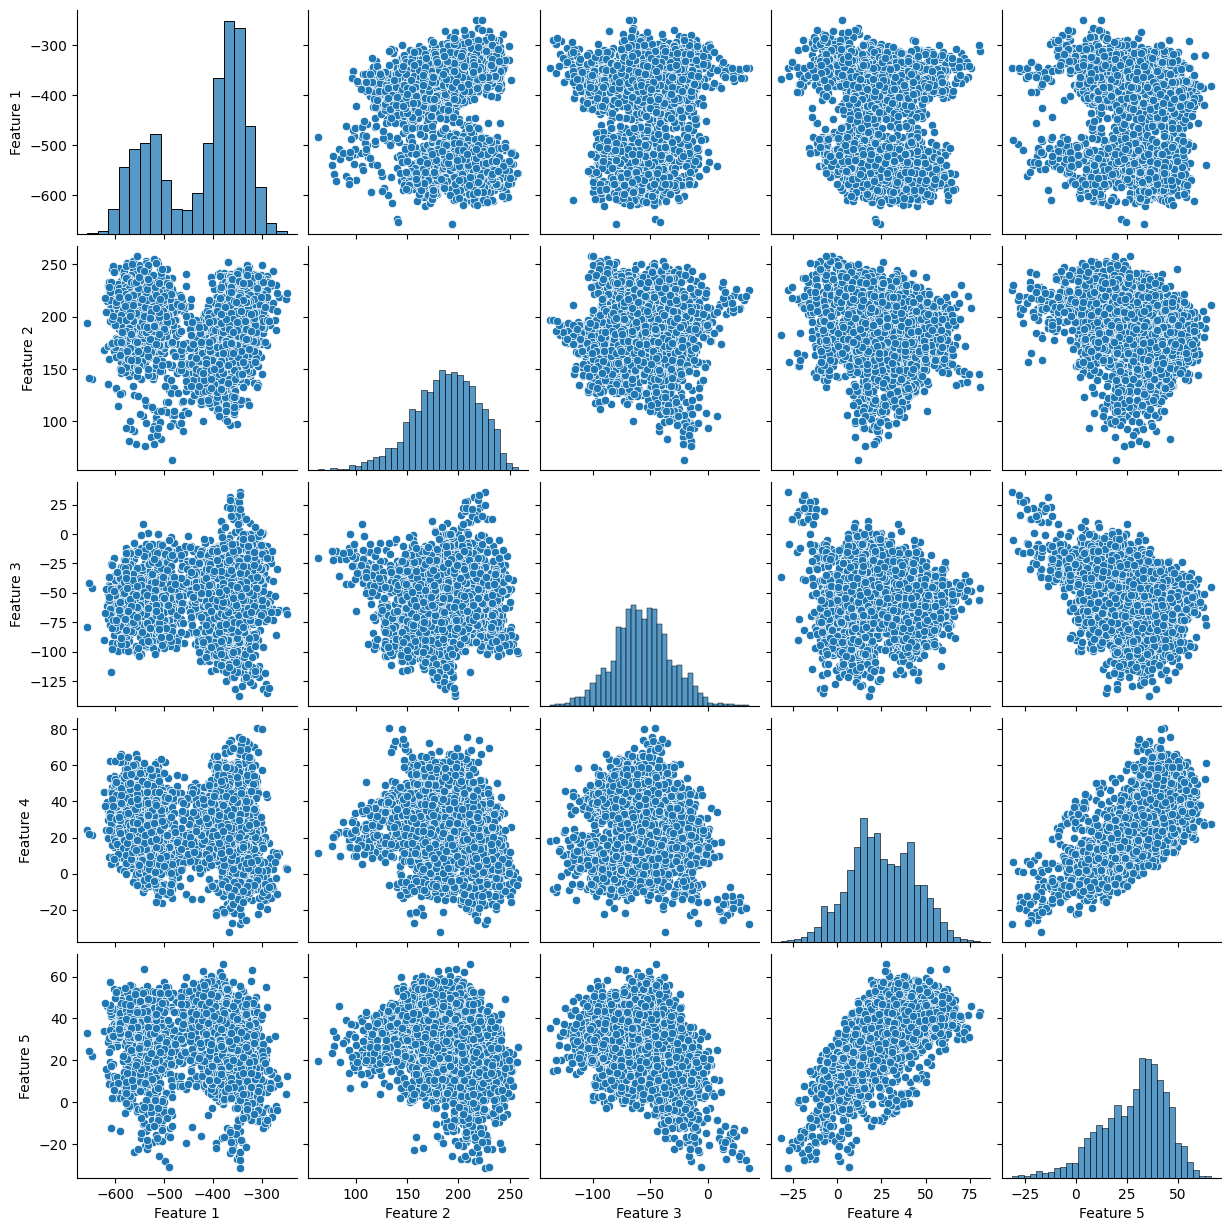

In [ ]:
# Scatter plot (without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f"Feature {i+1}" for i in range(5)])
sns.pairplot(df)
plt.show()


### Why is dimensionality reduction important?

Dimensionality reduction is important because it simplifies complex data and helps in visualization by projecting high-dimensional data into 2D or 3D, hence making it easier for interpretation.

Additionally, lower-dimensional data contains less noise of irrelevant and redundant data hence improving model performance and reducing overfitting by focusing on key features.

(*Document any challenges/errors from the above experiments.*)

- High-dimensional data creates cluttered visualizations making it difficult to analyse and interprete the data due to too many features being plotted in their raw form
- Using only the first 5 features for the pair plot may ignore important data in other features hence leading to inaccurate interpretation and model performance.


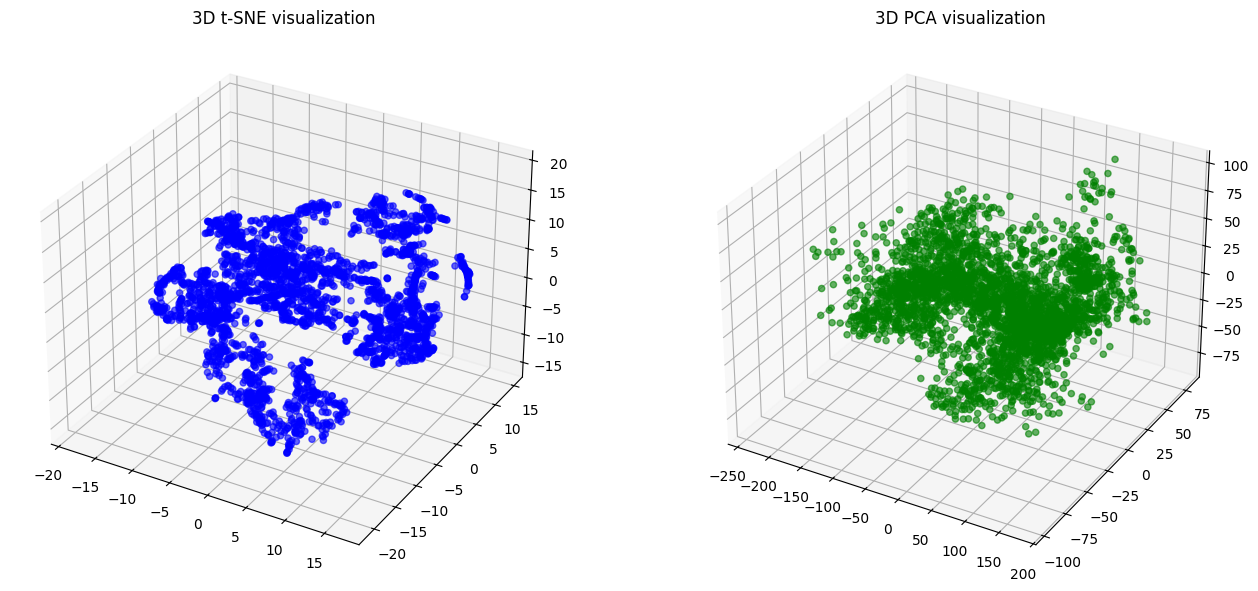

In [ ]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(14, 6))

#t-sne 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], alpha=0.6, c='blue')
ax1.set_title("3D t-SNE visualization")

#PCA 3D plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], alpha=0.6, c='green')
ax2.set_title("3D PCA visualization")

plt.tight_layout()
plt.show()



### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

Based on the visualizations above, the t-SNE 3D plot shows clear separation between clusters with the data points densely grouped and having noticeable gaps between them compared to PCA where the data points are packed together and have no clear separation between them, with little structure and separability.

This shows that T-SNE plot provides better separability of clusters compared to PCA because it preserves the local structure of the data hence revealing clusters in high-dimensional data unlike PCA which can distort the local structure and relationships between data points as it is a linear technique.



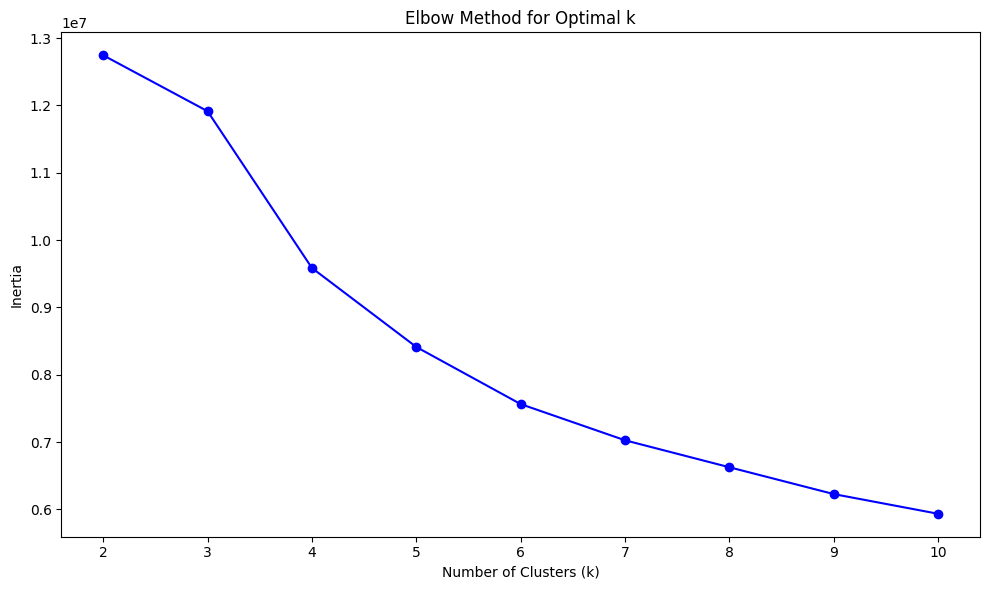

In [ ]:

# Optimize number of clusters using Elbow Method
def compute_inertia(data, k_range):
    inertia = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
    return inertia


inertia = compute_inertia(features_array, range(2, 11))
# Elbow method
plt.figure(figsize=(10,6))
plt.plot(range(2, 11), inertia, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.tight_layout()
plt.show()


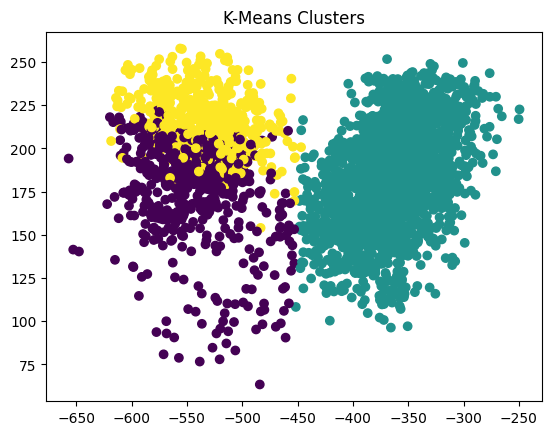

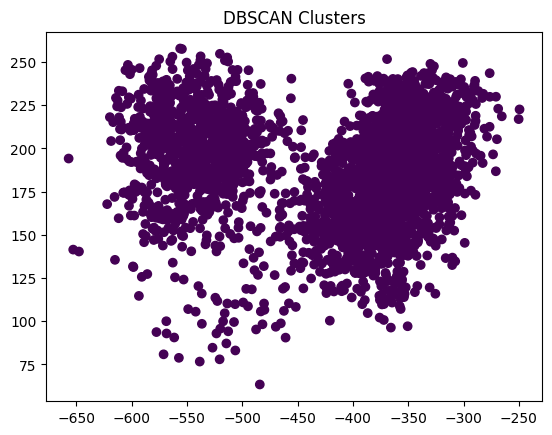

In [ ]:

# Select optimal K based on elbow method (e.g., k=3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

# Scatter Plot for K-Means Clusters
plt.scatter(features_array[:, 0], features_array[:, 1], c=kmeans_labels, cmap='viridis')
plt.title("K-Means Clusters")
plt.show()

# Scatter Plot for DBSCAN Clusters
plt.scatter(features_array[:, 0], features_array[:, 1], c=dbscan_labels, cmap='viridis')
plt.title("DBSCAN Clusters")
plt.show()


In [ ]:

# Evaluate clustering
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.4024, Davies-Bouldin Index: 1.4298
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

The silhoutte score of 0.4024 suggests a moderate cluster quality but it could be improved since optimal values should be above 0.5 with a Davies-Bouldin index of 1.43 which could also be lower.

DBSCAN failed to produce meaningful clusters which could be due to the dataset not containing dense structures or due to parameter settings which could be improved with further experimentation.

Overall, K-Means performed better according to the experiment outputs even though it could be improved with further optimization.

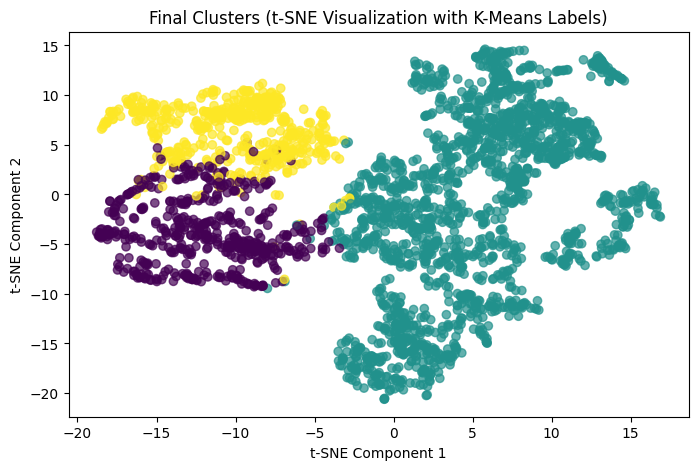

In [ ]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis

- Dimensionality reduction helped significantly in clustering by transforming the high-dimensional features into simpler 3D forms that are easier to visualize patterns and interprete the data.

- K-Means clustering performed better in comparison to DBSCAN as shown by the silhouette score of 0.4024 and the Davies-Bouldin index of 1.43 while DBSCAN failed to form meaningful clusters. This is likely due to K-Means being suitable for spherical clusters.

- These findings relate to real-world clustering challenges such as choosing the right algorithm and hyperparameter tuning especially since what works for one dataset may not apply well to another. However, with continuous iteration and experimentation we are able to find suitable algorithms and methods to produce models with good performance.